# Mapear los valores de accesibilidad en hexágonos
Una de las maneras de agrupar la información para encontrar patrones es a partir del uso de hexágonos, de esta manera se tiene una unidad definida de la misma manera para todo el espacio y se pueden hacer comparaciones entre diferentes partes geográficas.
Basado en: https://medium.com/@navaneeth.mohan94/how-to-create-a-hex-map-in-python-3f84602edb14

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
import sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

In [117]:
import osmnx as ox
import geopandas as gpd
import pandas as pd
import matplotlib.pyplot as plt
plt.style.use('dark_background')
import igraph as ig
import numpy as np
from shapely.geometry import Polygon
import src 
import networkx as nx
%matplotlib inline

In [4]:
ox.config(data_folder='../data',cache_folder='../data/raw', use_cache=True,log_console=True)

In [5]:
city = 'GDL'
#Área Metropolitana Guadalajara
mpos = gpd.read_file('../data/external/mex_admbnda_adm2_govmex/mex_admbnda_adm2_govmex.shp')
amg = mpos[mpos['ADM2_ES'].isin(['Guadalajara','Zapopan','El Salto','Ixtlahuacon de los Membrillos','Tlajomulco de Zueiga','Tlaquepaque','Tonale','Juanacatlun'])]
amg_boundary = amg.dissolve(by='ADM0_ES')
amg_boundary = amg_boundary[['geometry','ADM2_PCODE']] # keep only 'geometry' 

In [6]:
polygon = amg_boundary['geometry'][0]

In [11]:
nodes = gpd.read_file("../data/processed/GDL_nodes_distance.geojson")
nodes['X'] = nodes.geometry.x
nodes['Y'] = nodes.geometry.y

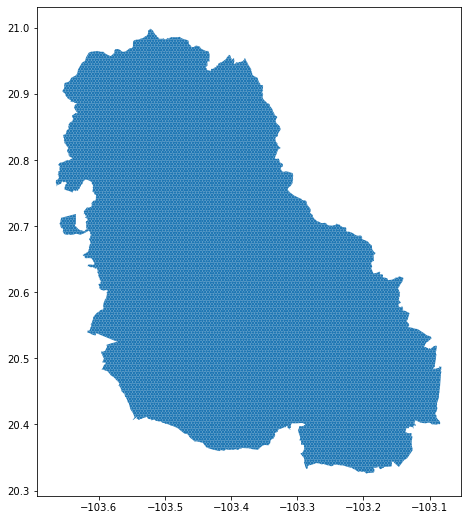

In [242]:
d = 500 #Tamaño del hexágono 750m
hex_bins = src.utils.create_hex_grid(amg_boundary,d)

In [243]:
hex_bins['hex_id'] = [i for i in range(len(hex_bins))]
pois_in_hex = gpd.sjoin(nodes, hex_bins)

pois_counts = pois_in_hex.groupby(['hex_id']).mean()
pois_counts.drop(['y','x','osmid','X','Y'],axis=1,inplace=True)

In [244]:
hex_new = pd.merge(hex_bins,pois_counts,right_index=True,left_on='hex_id')

In [245]:
edges = ox.graph_to_gdfs(G, nodes=False)
edges['highway'] = edges.highway.apply(lambda x: x[0] if type(x)== list else x )

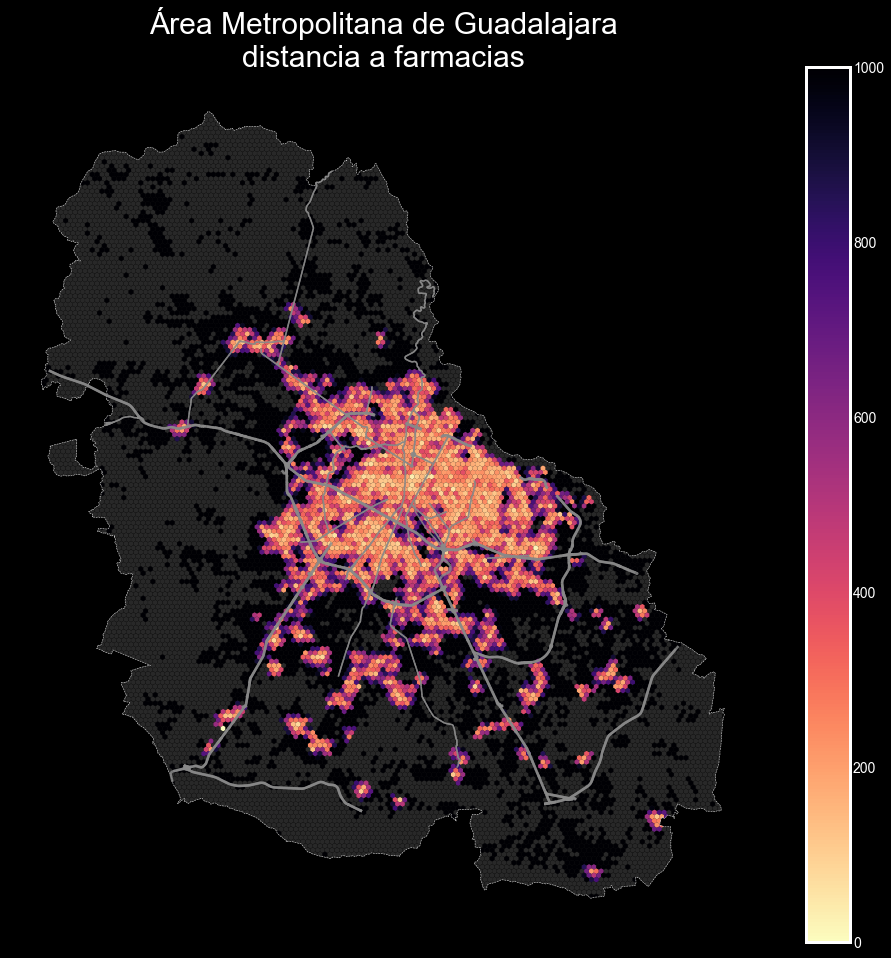

In [296]:
fig, ax = plt.subplots(1,1,figsize=(15,15))
hex_bins.plot(ax=ax,color='#2b2b2b', alpha=0.95, linewidth=0.1, edgecolor='k', zorder=0)
hex_new.plot(ax=ax,column='dist', cmap='magma_r',vmax=1000,zorder=1,legend=True)
amg_boundary.boundary.plot(ax=ax,color='#f8f8f8',zorder=2,linestyle='--',linewidth=0.5)
edges[(edges['highway']=='motorway') | (edges['highway']=='motorway_link')].plot(ax=ax,color='#898989',alpha=0.85,linewidth=2.5,zorder=3)
edges[(edges['highway']=='primary') | (edges['highway']=='primary_link')].plot(ax=ax,color='#898989',alpha=0.85,linewidth=1.5,zorder=3)
ax.set_title('Área Metropolitana de Guadalajara\ndistancia a farmacias',fontdict={'fontsize':30})
ax.axis('off')
plt.savefig('../output/figures/GDL_dist_farmacias.png',dpi=300);